# Network Anomaly Detection 
## 01. Data Exploration

### 1. Setup

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

sns.set(style="whitegrid")


### 2. Load Dataset

In [72]:
DATA_PATH = Path("../data/raw/nsl_kdd/KDDTrain+.txt")

columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells",
    "num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate",
    "srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate",
    "dst_host_srv_rerror_rate","label","difficulty"
]

df = pd.read_csv(DATA_PATH, names=columns)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (125973, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


#### 3. Dataset overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

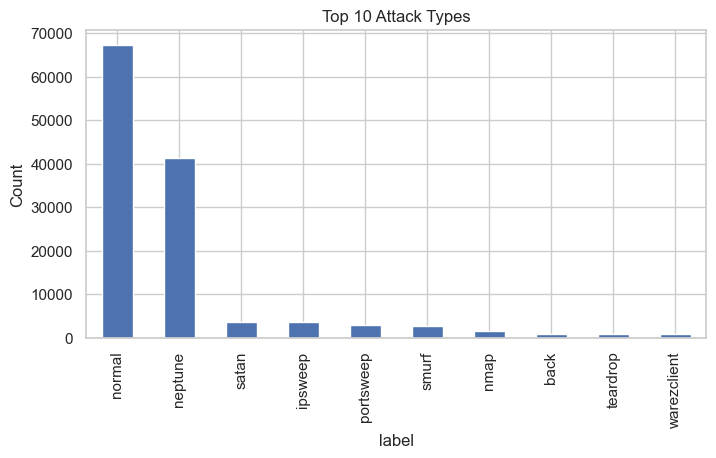

In [73]:
df.info()
df.isnull().sum()
df['label'].value_counts().head(10)

plt.figure(figsize=(8,4))
df['label'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Attack Types")
plt.ylabel("Count")
plt.show()


#### 4. Binary label

In [74]:
df['is_attack'] = (df['label'] != 'normal').astype(int)

df['is_attack'].value_counts()


is_attack
0    67343
1    58630
Name: count, dtype: int64

#### 5. Separate Normal vs Attack

In [75]:
df_normal = df[df['label'] == 'normal']
df_attack = df[df['label'] != 'normal']

print("Normal samples:", df_normal.shape)
print("Attack samples:", df_attack.shape)


Normal samples: (67343, 44)
Attack samples: (58630, 44)


### 6. Categorical Features overview

In [76]:
categorical_cols = ['protocol_type', 'service', 'flag']

for col in categorical_cols:
    print(f"\n{col} value counts (top 10):")
    print(df[col].value_counts().head(10))



protocol_type value counts (top 10):
protocol_type
tcp     102689
udp      14993
icmp      8291
Name: count, dtype: int64

service value counts (top 10):
service
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
eco_i        4586
other        4359
ecr_i        3077
telnet       2353
finger       1767
Name: count, dtype: int64

flag value counts (top 10):
flag
SF        74945
S0        34851
REJ       11233
RSTR       2421
RSTO       1562
S1          365
SH          271
S2          127
RSTOS0      103
S3           49
Name: count, dtype: int64


### 7. Numerical feature summary

In [77]:
numerical_cols = df.select_dtypes(include=['int64','float64']).columns

df[numerical_cols].describe().T[['mean','std','min','max']]


,mean,std,min,max
duration,287.144650,2.604515e+03,0.0,4.290800e+04
src_bytes,45566.743000,5.870331e+06,0.0,1.379964e+09
dst_bytes,19779.114421,4.021269e+06,0.0,1.309937e+09
land,0.000198,1.408607e-02,0.0,1.000000e+00
wrong_fragment,0.022687,2.535300e-01,0.0,3.000000e+00
urgent,0.000111,1.436603e-02,0.0,3.000000e+00
hot,0.204409,2.149968e+00,0.0,7.700000e+01
num_failed_logins,0.001222,4.523914e-02,0.0,5.000000e+00
logged_in,0.395736,4.890101e-01,0.0,1.000000e+00
num_compromised,0.279250,2.394204e+01,0.0,7.479000e+03


### 8. Comparision: Normal vs Attack

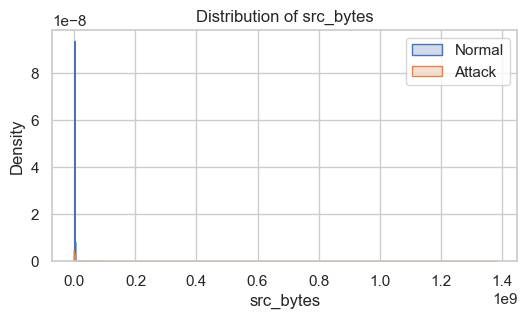

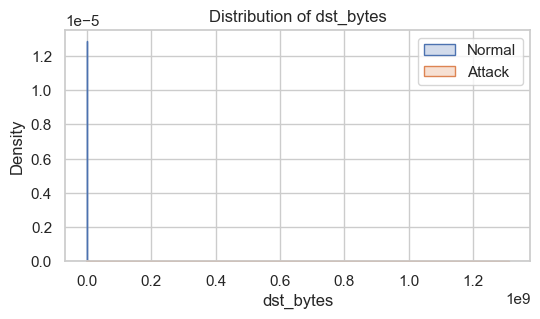

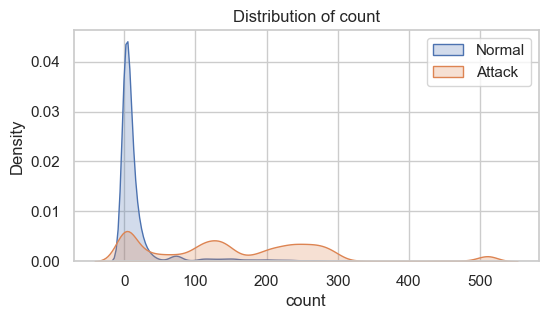

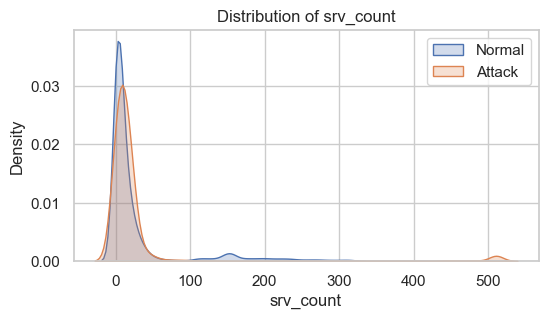

In [78]:
features_to_compare = ['src_bytes', 'dst_bytes', 'count', 'srv_count']

for col in features_to_compare:
    plt.figure(figsize=(6,3))
    sns.kdeplot(df_normal[col], label="Normal", fill=True)
    sns.kdeplot(df_attack[col], label="Attack", fill=True)
    plt.title(f"Distribution of {col}")
    plt.legend()
    plt.show()


### 9. Feature Selection 

In [79]:
drop_cols = ['label', 'difficulty']

feature_cols = [c for c in df.columns if c not in drop_cols + ['is_attack']]

print("Total features for modeling:", len(feature_cols))
feature_cols


Total features for modeling: 41


['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

#### 10. Summary
- The dataset contains multiple attack categories with highly imbalanced distributions.
- Normal and attack traffic exhibit distinct statistical behaviors across several numerical features.
- In accordance with anomaly detection principles, attack samples will not be used during model training.
- Categorical features (protocol_type, service, flag) will be one-hot encoded to preserve semantic meaning.
- Data preprocessing and model training will be conducted exclusively on normal traffic samples.
